# Mini Projet - à quoi tu ressembles sans ton masque ?

Avec la pandémie de la Covid-19, nous avons appris à porter des masques quotidiennement. 
Désormais la moitié de notre visage est cachée nous laissant le regard pour seul moyen d'expression visible. Cette opération de restaurer le visage s'apparente à un domaine en traitement d'images et de vidéos appelé *inpainting*. En effet, les pixels correspondant à la zone du masque (modélisé par un rectangle) sont mis à 0. Et l'ACP et les *eigenfaces* permettent, entre autres, de restaurer la zone dégradée.  


L'**objectif de ce mini projet** consiste à combler la zone de masque par un visage qui est le plus semblable à l'aide de l'ACP et des $k$ plus proches voisins.

In [163]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib import image
from random import *
from sklearn.metrics.pairwise import euclidean_distances
import random

## Chargement des données

La base de données sur laquelle ce projet est appliqué est une collection d'images utiles pour mener des expériences en psychologie (*Psychological Image Collection at Stirling* (PICS) :http://pics.stir.ac.uk). 

<img src="files/base.PNG" width="800" height="600"  >

Elle comporte 32 personnes (16 hommes et 16 femmes) avec 6 postures/expressions  faciales : 2 postures (face et trois quart face) et 3 émotions différentes par posture.



16


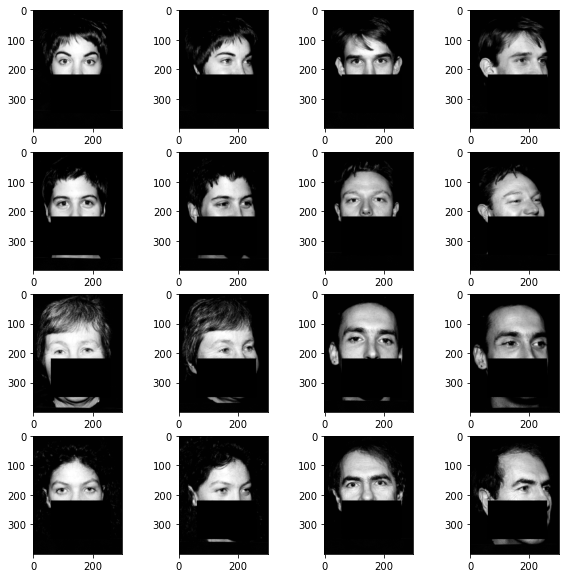

In [157]:
# Chargement des données de visages masqués : 192 x 120000
X_DataMask=np.load('DataMask.npy')
X_Data=np.load('Data.npy')



# Création de la base d'apprentissage : exemple à modifier
X_App=X_DataMask[np.arange(0,48,3),:] 
print(X_App.shape[0])


X_data=X_Data[np.arange(0,48,3),:] 



# Affichage des visages masqués de la base d'apprentissage
plt.figure(figsize=(10,10))
compt=0
for i in range(0,X_App.shape[0]):
    im=np.reshape(X_App[i,:],(400,300))
    plt.subplot(4,4,compt+1)
    compt=compt+1
    plt.imshow(im,cmap='gray')
    
plt.show()    



In [158]:
# méthodes permettant d'afficher les n prémieres images dont les indices se trouvent dans indices

def showImages(Data,indices,n):
    
    plt.figure(figsize=(10,10))
    compt=0
    for i in range(n):
        indice = indices[:,i]
        im=np.reshape(Data[indice,:],(400,300))
        plt.subplot(4,4,compt+1)
        compt=compt+1
        plt.imshow(im,cmap='gray')
    plt.show()
    
    return

##  Eigenfaces et réduction de dimensions par ACP

Complétez la fonction *eigenfaces*, qui vise à calculer les axes
principaux des images d'apprentissage à partir des vecteurs propres associés
aux $n-1$ valeurs propres non nulles de la matrice de variance/covariance
$\Sigma$ des données/.


<img src="files/Eigenfaces.PNG" width="600" height="500"  >

**Remarque :**  la
    fonction *np.linalg.eig* ne peut pas être directement appliquée à $\Sigma$. En
    effet, sa taille $p\times p$ est gigantesque ($p = 120000$). Or, pour une
    matrice $\text{M}$ quelconque, $\text{M}^\top \text{M}$ et
    $\text{M}\,\text{M}^\top$ ont les mêmes valeurs propres **non nulles**.
    On peut donc appliquer la fonction *np.linalg.eig* à $\Sigma_2 = \text{X}_c \,
    \text{X}_c^\top/n$, de taille $n\times n$ beaucoup plus petite, pour
    calculer les valeurs propres non nulles de $\Sigma$.

(1, 16)


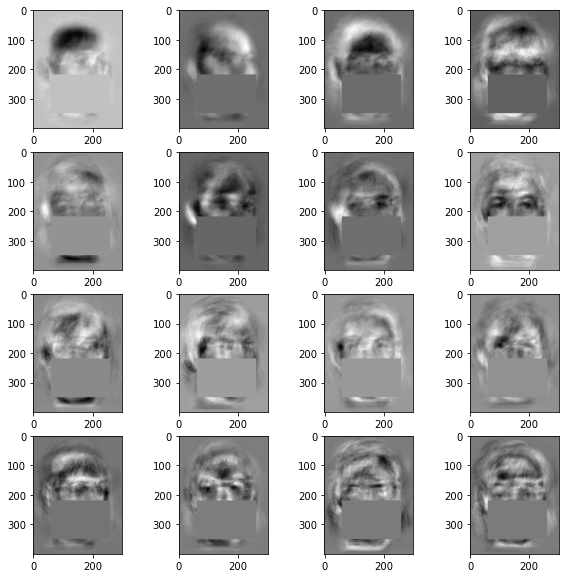

In [159]:
def eigenface(X_App,nb_component):
    
    
    Xc = X_App-np.mean(X_App, axis=0)
    sigma2 = np.cov(Xc)
    vals,vec = np.linalg.eig(sigma2)
    vecs = np.dot(Xc.T,vec)
    vecs = np.real(vecs)
    cp = np.dot(X_App,vecs)

    return cp,vecs

cp,vecs = eigenface(X_DataMask,16)

# affichage des images
n = 16
indices = [i for i in range(n)]
indices = np.reshape(indices,(1,n))
print(indices.shape)
showImages( vecs.T,indices,16)
    

## Reconnaissance par kppv

En tirant aléatoirement une image de test, parmi les 32 personnes et les 6 postures faciales disponibles dans la base de données complète, complétez une fonction pour trouver l'individu (personne+posture) dans la base d'apprentissage qui est le plus proche de l'image de test (vous pouvez utiliser et adapter la fonction \texttt{kppv} que vous avez écrite lors du TP2). 

L'image test : 



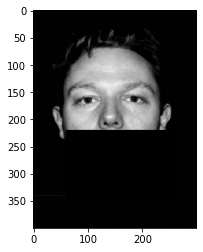

Les  16  plus proches images: 



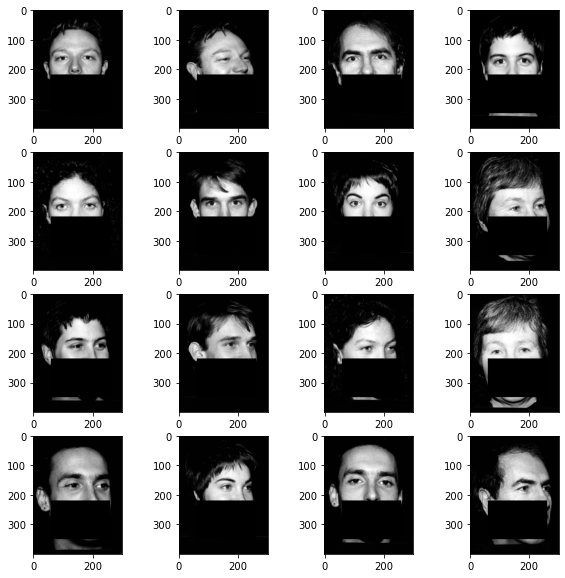

(1, 16)


In [160]:

def kppv(DataApp,imageTest,k):
    
    # calcul des axes principaux et composantes principaux
    cp,vecs = eigenface(DataApp,k)
    imageTest = np.dot(imageTest[:],vecs)
    
    # indices des plus proches voisins
    distances = euclidean_distances([imageTest],cp) 
    indicesVoisin = np.argsort(distances) 
    
    # affichages des k proches images
    print("Les ",k," plus proches images: \n")
    showImages(DataApp,indicesVoisin,k)

    return indicesVoisin

# méthode permettant de génerer aléatoirement une image et de l'afficher
# Data => base dans laquelle l'image est prise

def getRandomIm(Data):
    
    #choix aléatoire de l'image
    randomIndice = randint(0,15)
    # copy pour ne pas modifier l'image initiale à la phase de reconstruction
    imageTest = np.copy(Data[randomIndice,:])
    
    print("L'image test : \n")
    plt.imshow(np.reshape(imageTest,(400,300)),cmap='gray')
    plt.show()
    
    return imageTest


im = getRandomIm(X_App)
indices = kppv(X_App,im,16)
print(indices.shape)

## Reconstruction et évaluation

A partir de la question précédente, implémentez la reconstruction de la zone du masque  en remplaçant la zone correspondant au masque par la zone de l'image de la base d'apprentissage de visages entiers (fichier **Data.npy**) la plus proche dans l'espace défini par les eigenfaces masqués.


Pour pouvoir remplir la zone du masque, nous nous appuyons sur le travail de M. Turk et A. Pentland intitulé «Eigenfaces for
Recognition» : https://www.mitpressjournals.org/doi/pdfplus/10.1162/jocn.1991.3.1.71 

L'image test : 



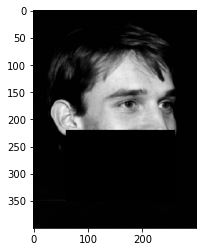

Les  12  plus proches images: 



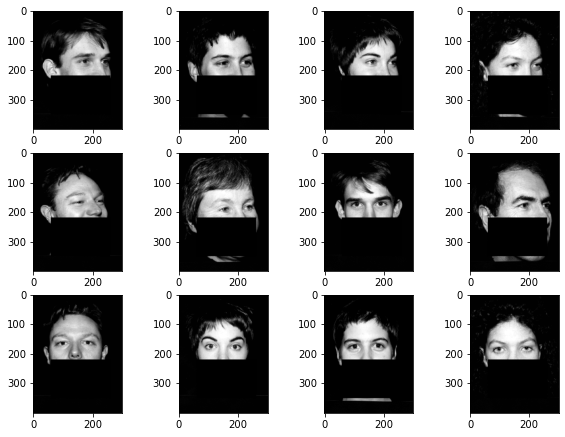

L'image reconstruite : 



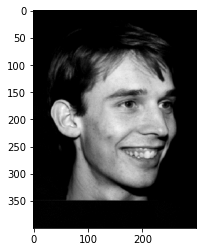

In [161]:
# méthode de la reconstruction des images

def reconstruire(data,imTest,indices):
    
    # récuperation et reshape de l'image non masquée dans data
    im = np.reshape(data[int(indices[:,0]),:],(400,300))
    imTest = np.reshape(imTest,(400,300))
    
    #reconstutition de la zone masquée
    imTest[220:350,60:260] = im[220:350,60:260]
    
    #affichage de l'image reconstruite
    print("L'image reconstruite : \n")
    plt.imshow(imTest,cmap='gray')
    plt.show()
    
    return imTest

#test
Im = getRandomIm(X_App)
indices = kppv(X_App,Im,12)

im_reconstruite = reconstruire(X_data,Im,indices)

L'image test : 



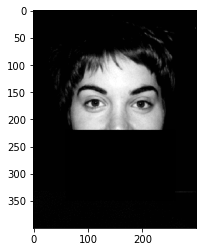

Les  12  plus proches images: 



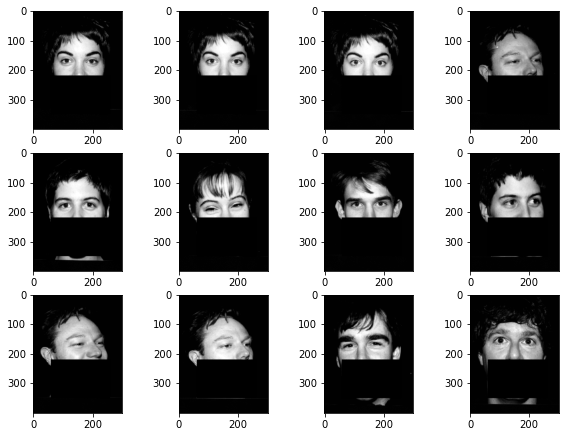

L'image reconstruite : 



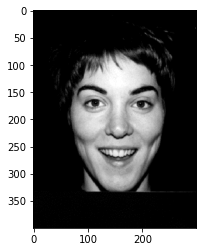

Les  12  plus proches images: 



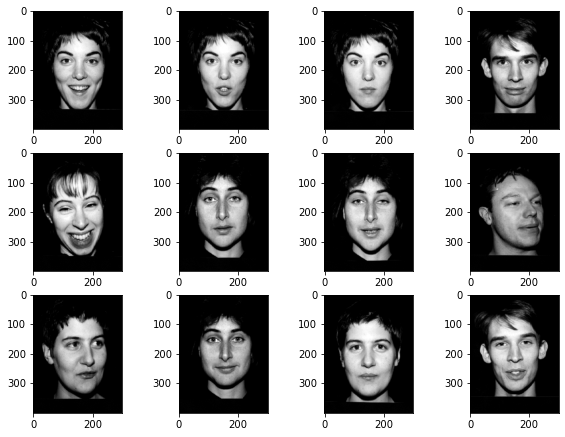

In [162]:
#  ÉVALUATION

def evaluation(Data,imTest,k):

    # kppv en considérant l'image reconstruite
    imTest = np.reshape(imTest,(120000))
    indices = kppv(Data,imTest,k)
    
    return indices

# reconstruction d'une image masquée
imTest = getRandomIm(X_DataMask)
indices = kppv(X_DataMask,imTest,12)
reconstructed_im = reconstruire(X_Data,imTest,indices)
# évaluation
e = evaluation(X_Data,reconstructed_im,12)